In [1]:
import os
from pathlib import Path
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, \
    Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Create necessary dirs
PATH_MODEL = Path('model')
PATH_MODEL.mkdir(exist_ok=True)
PREDS_PATH = Path('predictions')
PREDS_PATH.mkdir(exist_ok=True)

print(tf.__version__)

2.1.0


In [2]:
!ls data/train.rotfaces/train | head -n 20

0-10049200_1891-09-16_1958.jpg
0-10110600_1985-09-17_2012.jpg
0-10126400_1964-07-07_2010.jpg
0-1013900_1917-10-15_1960.jpg
0-10166400_1960-03-12_2008.jpg
0-102100_1970-10-09_2008.jpg
0-1024100_1982-06-07_2011.jpg
0-10292500_1984-03-26_2009.jpg
0-1035700_1945-11-27_2013.jpg
0-10416800_1907-01-08_1967.jpg
0-10525500_1916-02-14_1951.jpg
0-1054800_1947-09-19_2011.jpg
0-10623500_1931-09-25_1956.jpg
0-10726900_1991-02-03_2010.jpg
0-10870400_1971-06-28_2013.jpg
0-10898800_1951-06-03_1950.jpg
0-10967900_1956-03-18_2007.jpg
0-10996600_1988-06-15_2008.jpg
0-11035100_1984-08-03_2009.jpg
0-1121500_1976-07-31_2007.jpg
ls: write error: Broken pipe


In [3]:
img_label = pd.read_csv('data/train.rotfaces/train.truth.csv')
img_label.head()

,fn,label
0,0-10049200_1891-09-16_1958.jpg,rotated_left
1,0-10110600_1985-09-17_2012.jpg,rotated_left
2,0-10126400_1964-07-07_2010.jpg,upright
3,0-1013900_1917-10-15_1960.jpg,rotated_right
4,0-10166400_1960-03-12_2008.jpg,upside_down


In [4]:
label_encoding = {label: enc for enc, label in enumerate(img_label.label.unique())}
label_encoding

{'rotated_left': 0, 'upright': 1, 'rotated_right': 2, 'upside_down': 3}

In [5]:
TRAIN_PATH = Path('data/train.rotfaces/')
TRAIN_PATH_IMGS = TRAIN_PATH / 'train'

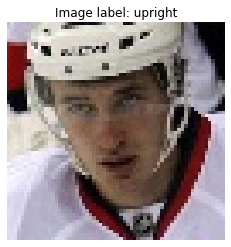

In [6]:
# Sample and show one random image
rand_img = np.random.choice(np.array(os.listdir(TRAIN_PATH_IMGS)))
label = img_label.query('fn == @rand_img').label.values[0]
rand_img = cv2.imread(str(TRAIN_PATH_IMGS / rand_img))
rand_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)
plt.imshow(rand_img)
plt.title(f'Image label: {label}')
plt.axis('off')
plt.show()

In [7]:
train, val = train_test_split(img_label, test_size=.3, shuffle=True, random_state=10)
train.head()

,fn,label
9625,17-5164117_1981-01-21_2007.jpg,upside_down
48032,88-26798288_1987-04-10_2009.jpg,rotated_left
22144,40-5612440_1975-04-02_2014.jpg,rotated_left
42666,78-45505878_1987-06-10_2014.jpg,upside_down
44160,81-29596781_1948-04-06_2009.jpg,rotated_left


In [8]:
def img_generator(dataset):
    for idx, items in dataset.iterrows():
        img = cv2.imread(str(TRAIN_PATH_IMGS / items['fn']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
#         img = preprocess_input(img)
        label = label_encoding[items['label']]
        yield img, label

In [9]:
BATCH_SIZE = 200
STEPS_PER_EPOCH = train.shape[0] // BATCH_SIZE
STEPS_VAL = val.shape[0] // BATCH_SIZE
train_gen = partial(img_generator, train)
val_gen = partial(img_generator, val)
train_ds = tf.data.Dataset.from_generator(train_gen,
                                            (tf.float64, tf.int32),
                                            (tf.TensorShape([64, 64, 3]), tf.TensorShape([])))
val_ds = tf.data.Dataset.from_generator(val_gen,
                                         (tf.float64, tf.int32),
                                         (tf.TensorShape([64, 64, 3]), tf.TensorShape([])))


train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)

train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

train_ds.take(1)

<TakeDataset shapes: ((200, 64, 64, 3), (200,)), types: (tf.float64, tf.int32)>

In [10]:
# CIFAR10 example model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoding.values())))
model.add(Activation('softmax'))

In [11]:
# feat_map = VGG16(
#     input_shape=(64, 64, 3),
#     weights='imagenet',
#     include_top=False)
# feat_map.trainable = False
# x = Flatten()(feat_map.output)
# x = Dense(128)(x)
# x = Activation('relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(256)(x)
# x = Activation('relu')(x)
# # x = Dropout(0.5)(x)
# x = Dropout(0.25)(x)
# x = Dense(512)(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(len(label_encoding.values()))(x)
# x = Activation('softmax')(x)

# model = Model(feat_map.input, x)

In [12]:
# RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        1

In [14]:
PATH_MODEL_OBJ = PATH_MODEL / 'trained_model'
EPOCHS = 5
# Fit the model
if not PATH_MODEL_OBJ.exists():
    model.fit(train_ds,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_data=val_ds,
              validation_steps=STEPS_VAL,
              epochs=EPOCHS)
    model.save(str(PATH_MODEL_OBJ))
else:
    model = tf.keras.models.load_model(str(PATH_MODEL_OBJ))

In [15]:
TEST_PATH_IMGS = Path('data/test.rotfaces/test')
class model_wrapper:
    def __init__(self, model, label_encoding):
        self.model = model
        self.label_encoding = label_encoding
        self.encoding_label = {enc: label for label, enc in self.label_encoding.items()}
    def predict(self, path: Path):
        path_df = self._get_path_list(path)
        img_gen = self._image_gen(path_df, path)
        preds = self.model.predict(img_gen)
        preds = np.argmax(preds, axis=1)
        preds = np.vectorize(self._encoding_to_label)(preds)
        pred_df = pd.concat([path_df, pd.Series(preds, name='label')], axis=1)
        return pred_df
    
    def correct_orientations(self, input_dir: Path, output_dir: Path, 
                             output_fmt='png', output_numpy=False):
        pred_df = self.predict(input_dir)
        self.correct_orientations_from_df(pred_df, output_dir, 
                                          output_fmt, output_numpy=output_numpy)
        
    def correct_orientations_from_df(self, pred_df, input_dir: Path, 
                                     output_dir: Path, output_fmt='png', output_numpy=False):
        inp_img_paths = pred_df['fn'].map(lambda x: input_dir / x).values
        
        if not output_numpy:
            correct_img_func = partial(self.correct_img, output_dir=output_dir, 
                                   output_fmt=output_fmt)
            np.vectorize(correct_img_func)(inp_img_paths, pred_df['label'].values)
        else:
            correct_img_func = partial(self.correct_img, output_dir=output_dir, 
                                   output_fmt=output_fmt, output_img=output_numpy)
            return np.vectorize(correct_img_func,
                               signature='(),()->(h,w,c)')(inp_img_paths, 
                                                           pred_df['label'].values)
        
        
    def correct_img(self, img_path, distortion, output_dir: Path, output_fmt, output_img=False):
        _, img_name = os.path.split(img_path)
        img_name = '.'.join([img_name.split('.')[0], output_fmt])
        img = Image.open(img_path)
        if distortion == 'rotated_left':
            correct_img = img.rotate(-90)
        elif distortion == 'rotated_right':
            correct_img = img.rotate(90)
        elif distortion == 'upside_down':
            correct_img  = img.transpose(Image.ROTATE_180)
        elif distortion == 'upright':
            correct_img = img
        else:
            raise ValueError('Unknown label.')
        correct_img.save(output_dir / img_name)
        if output_img:
            width, height = correct_img.size
            return np.array(correct_img.getdata()).reshape(height, width, 3)
        
        
    @staticmethod
    def _image_gen(path_df, dir_: Path):
        for idx, items in path_df.iterrows():
            img = cv2.imread(str(dir_ / items['fn']))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0
            yield np.expand_dims(img, axis=0)
    @staticmethod
    def _get_path_list(path: Path):
        path_list = os.listdir(path)
        path_df = pd.DataFrame(path_list, columns=['fn'])
        return path_df
    def _encoding_to_label(self, enc):
        return self.encoding_label[enc]
        
    

In [16]:
predictor = model_wrapper(model, label_encoding)
predictor

In [17]:
PREDS_PATH_CSV = PREDS_PATH / 'preds.csv'
if not PREDS_PATH_CSV.exists():
    pred_df = predictor.predict(TEST_PATH_IMGS)
    pred_df.to_csv(PREDS_PATH_CSV, index=False)
else:
    pred_df = pd.read_csv(PREDS_PATH_CSV)
pred_df.head()

,fn,label
0,94-6717694_1988-04-03_2011.jpg,upright
1,94-2208994_1916-01-06_1964.jpg,rotated_right
2,99-513099_1930-09-19_1959.jpg,upside_down
3,92-33455292_1990-09-08_2013.jpg,upright
4,91-7294591_1987-12-25_2011.jpg,upright


In [18]:
PREDS_PATH_IMGS = PREDS_PATH / 'images'
PREDS_PATH_IMGS.mkdir(exist_ok=True)
img_numpy = predictor.correct_orientations_from_df(pred_df, 
                                                   TEST_PATH_IMGS,
                                                   PREDS_PATH_IMGS,
                                                   output_numpy=True)

In [19]:
img_numpy.shape

(5361, 64, 64, 3)

In [20]:
np.save(PREDS_PATH / 'corrected_images.npy', img_numpy)
del img_numpy

In [21]:
print('DONE!')

DONE!
